In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image


Data Augmentation And Preprocessing

In [26]:
#Define Preprocessing and Data Loading
transform = transforms.Compose([
    transforms.Resize((32,32)),  # Resize images to 32x32
    transforms.RandomRotation(15),  # Randomly rotate images
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0, 0, 0], std=[1,1,1])  # Normalize to [-1, 1]
])

In [27]:
dataset = datasets.ImageFolder(root='photos', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

In [28]:
# Check the number of data points in the dataset
num_samples = len(dataset)
print(f"Number of samples in the dataset: {num_samples}")

# Check the number of batches in the DataLoader
num_batches = len(dataloader)
print(f"Number of batches in the DataLoader: {num_batches}")


Number of samples in the dataset: 4000
Number of batches in the DataLoader: 125


Model 1 with Size (32,32)


In [29]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
# Step 2: Define VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.Flatten()  # Flatten to (batch_size, 128 * 4 * 4) = (batch_size, 2048)
        )

        # Latent space layer (mu, log_var)
        self.fc_mu = nn.Linear(128 * 4 * 4, 512)  # Latent mean
        self.fc_log_var = nn.Linear(128 * 4 * 4, 512)  # Latent log-variance

        # Decoder
        self.decoder_fc = nn.Linear(512, 128 * 4 * 4)  # Fully connected layer to match encoder's output size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 3, 32, 32)
            nn.Sigmoid()  # Sigmoid for normalized output [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_fc(z)  # Fully connected layer to match the decoder input size
        z = z.view(-1, 128, 4, 4)  # Reshape to (batch_size, 128, 4, 4)
        return self.decoder(z)  # Decode to (batch_size, 3, 32, 32)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var

# Step 3: Define the loss function for VAE
def vae_loss(recon_x, x, mu, log_var):
    # Binary Cross-Entropy for reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3 * 32 * 32), x.view(-1, 3 * 32 * 32), reduction='sum')
    # KL divergence
    D_KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + D_KL

# Step 4: Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Step 5: Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, log_var = model(data)
        
        # Compute the loss
        loss = vae_loss(recon_batch, data, mu, log_var)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        train_loss += loss.item()
    
    # Log the training loss
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')



Epoch 1, Loss: 2137.092021484375
Epoch 2, Loss: 2132.05708984375
Epoch 3, Loss: 2126.46689453125
Epoch 4, Loss: 2120.228794921875
Epoch 5, Loss: 2112.621740234375


Loss is Decreasing but needs normalization

Epoch 1, Normalized Loss: 0.92
Epoch 2, Normalized Loss: 0.918
Epoch 3, Normalized Loss: 0.916
Epoch 4, Normalized Loss: 0.914
Epoch 5, Normalized Loss: 0.911
Epoch 6, Normalized Loss: 0.91
Epoch 7, Normalized Loss: 0.908
Epoch 8, Normalized Loss: 0.906
Epoch 9, Normalized Loss: 0.904
Epoch 10, Normalized Loss: 0.903


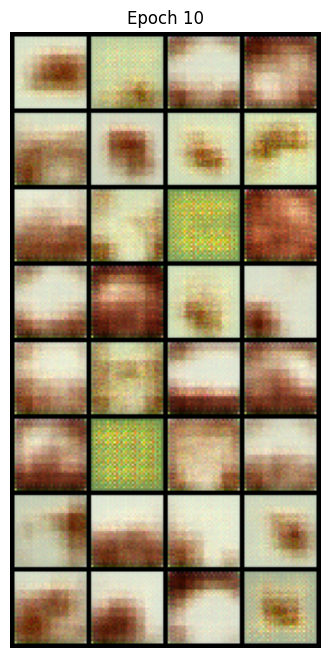

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Assuming you have the VAE model and DataLoader defined.

# Training loop
num_epochs = 10
loss_max =  2137.092021484375  # Set the max loss observed during initial training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, log_var = model(data)
        
        # Calculate loss
        loss = vae_loss(recon_batch, data, mu, log_var)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    if loss_max != 0:
        normalized_loss = running_loss / loss_max
    else:
         normalized_loss = 0 
    normalized_loss_per_sample = normalized_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}, Normalized Loss: {round(normalized_loss_per_sample, 3)}")
    
    # Visualize the reconstructed images every epoch
    if (epoch + 1) % 10 == 0:  # Change this to save or show images per epoch
        model.eval()
        with torch.no_grad():
            recon_images, _, _ = model(data)
            # Denormalize the images
            recon_images = recon_images * 0.5 + 0.5  #denormalize to [0, 1]
            
            # Convert tensor to grid and display
            grid = vutils.make_grid(recon_images.cpu(), nrow=4, normalize=True, scale_each=True)
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0))  # Change from CHW to HWC format
            plt.title(f"Epoch {epoch+1}")
            plt.axis('off')
            plt.show()


Tracking Loss KL,Recon and Total

Epoch 1: Recon Loss: 68.0603, KL Loss: 3.2772, Total Loss: 71.3375
Epoch 2: Recon Loss: 54.5403, KL Loss: 5.9851, Total Loss: 60.5254
Epoch 3: Recon Loss: 52.5992, KL Loss: 6.2303, Total Loss: 58.8295
Epoch 4: Recon Loss: 51.4490, KL Loss: 6.4660, Total Loss: 57.9150
Epoch 5: Recon Loss: 51.0732, KL Loss: 6.5759, Total Loss: 57.6491
Epoch 6: Recon Loss: 49.7370, KL Loss: 7.3755, Total Loss: 57.1124
Epoch 7: Recon Loss: 48.7542, KL Loss: 7.5966, Total Loss: 56.3509
Epoch 8: Recon Loss: 48.5041, KL Loss: 7.6784, Total Loss: 56.1825
Epoch 9: Recon Loss: 48.0216, KL Loss: 7.8139, Total Loss: 55.8355
Epoch 10: Recon Loss: 48.0435, KL Loss: 7.9264, Total Loss: 55.9699


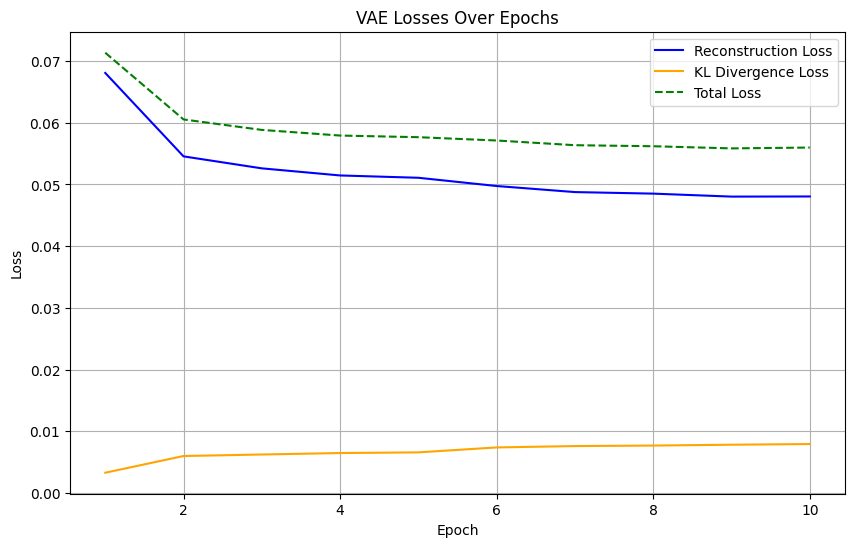

In [33]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Initialize variables for tracking losses
num_epochs = 10
reconstruction_losses = []
kl_divergence_losses = []
total_losses = []

for epoch in range(num_epochs):
    model.train()
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_total_loss = 0.0

    # Training phase
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, log_var = model(data)

        # Calculate losses
        recon_loss = ((recon_batch - data) ** 2).mean()  # Example reconstruction loss (MSE)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
        total_loss = recon_loss + kl_loss  # VAE total loss

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        running_total_loss += total_loss.item()

    # Normalize losses by number of batches
    avg_recon_loss = running_recon_loss / len(train_loader)
    avg_kl_loss = running_kl_loss / len(train_loader)
    avg_total_loss = running_total_loss / len(train_loader)

    # Store losses for plotting
    reconstruction_losses.append(avg_recon_loss)
    kl_divergence_losses.append(avg_kl_loss)
    total_losses.append(avg_total_loss)

    # Print epoch-wise loss
    print(f"Epoch {epoch + 1}: Recon Loss: {avg_recon_loss*1000:.4f}, KL Loss: {avg_kl_loss*1000:.4f}, Total Loss: {avg_total_loss*1000:.4f}")

# Plotting losses
plt.figure(figsize=(10, 6))

# Plot Reconstruction Loss
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label="Reconstruction Loss", color="blue")

# Plot KL Divergence Loss
plt.plot(range(1, num_epochs + 1), kl_divergence_losses, label="KL Divergence Loss", color="orange")

# Plot Total Loss
plt.plot(range(1, num_epochs + 1), total_losses, label="Total Loss", color="green", linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Observations from the Plot:
KL Divergence Loss:

Gradually decreases, indicating that the latent space representation is becoming more aligned with the prior distribution (e.g., Gaussian).
Reconstruction Loss:

Appears almost constant with very minimal changes, suggesting that the model might already be good at reconstructing inputs or the learning rate may be too small to improve further.
Total Loss:

Shows a slight decrease as KL Divergence contributes less over epochs, which is expected behavior in training VAEs.


It looks like my model's total loss and reconstruction loss are decreasing over time, but the KL divergence loss is relatively small compared to the reconstruction loss. This suggests that my model is primarily focusing on minimizing the reconstruction error and not paying as much attention to the regularization term (KL divergence).

This behavior might indicate a couple of things:

- **KL Divergence Impact**: If the KL divergence loss is too small, my model might not be regularizing the latent space as expected. I may need to find a better balance between the reconstruction loss and KL divergence.
- **Vanishing KL Divergence**: Sometimes, the KL divergence can become too small (especially with a relatively large capacity in the decoder), which could mean that there's not enough pressure on the latent space to stay well-structured.